### **Load and select indicators**

In [3]:
import pandas as pd

df = pd.read_csv("/content/city_metrics.csv")

indicator_cols = [
    "road_density_km_km2_norm",
    "health_facilities_per_100k_pop_norm",
    "intersection_density_norm",
    "hotels_per_100k_norm",
    "airport_distance_km_norm",
    "open_space_per_100k_pop_norm",
    "population_density_norm"
]


### **Sanity checks**

In [4]:
# Ensure all indicators are bounded correctly
assert df[indicator_cols].min().min() >= 0
assert df[indicator_cols].max().max() <= 1

# Check for missing values
assert df[indicator_cols].isnull().sum().sum() == 0

### **Compute equal-weight index**

In [5]:
df["event_readiness_index"] = df[indicator_cols].mean(axis=1)

### **Rank cities**

In [6]:
df = df.sort_values("event_readiness_index", ascending=False)

df[["city", "event_readiness_index"]]

,city,event_readiness_index
2,Kampala,0.682095
0,Kigali,0.634536
3,Dar es Salaam,0.517647
4,Rabat,0.447720
1,Nairobi,0.398530
5,Casablanca,0.277970


### **Indicator contribution sanity check**

In [7]:
import numpy as np

contributions = df[indicator_cols].div(df["event_readiness_index"], axis=0)
contributions.describe()

,road_density_km_km2_norm,health_facilities_per_100k_pop_norm,intersection_density_norm,hotels_per_100k_norm,airport_distance_km_norm,open_space_per_100k_pop_norm,population_density_norm
count,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000
mean,0.898456,0.468967,0.866517,1.136793,1.262679,1.299163,1.067425
std,0.892309,0.532248,0.666021,0.714400,0.817689,1.098723,0.615493
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.199495,0.162334,0.406990,0.777350,0.866401,0.405719,0.891195
50%,0.691517,0.291845,0.853997,1.251397,1.315245,1.490519,1.153853
75%,1.476883,0.556621,1.404880,1.637959,1.778313,1.831134,1.534266
max,2.233540,1.466071,1.644610,1.931819,2.296127,2.825150,1.632131


### **Rank consistency check**

In [9]:
rank_results = {}

for col in indicator_cols:
    cols_subset = [c for c in indicator_cols if c != col]
    temp_index = df[cols_subset].mean(axis=1)
    rank_results[col] = temp_index.rank(ascending=False)

rank_df = pd.DataFrame(rank_results)
rank_df["baseline"] = df["event_readiness_index"].rank(ascending=False)
rank_df

,road_density_km_km2_norm,health_facilities_per_100k_pop_norm,intersection_density_norm,hotels_per_100k_norm,airport_distance_km_norm,open_space_per_100k_pop_norm,population_density_norm,baseline
2,2.0,2.0,1.0,2.0,1.0,1.0,1.0,1.0
0,1.0,1.0,2.0,1.0,2.0,2.0,2.0,2.0
3,3.0,3.0,3.0,3.0,3.0,5.0,3.0,3.0
4,5.0,4.0,4.0,4.0,4.0,3.0,4.0,4.0
1,4.0,5.0,5.0,5.0,6.0,4.0,5.0,5.0
5,6.0,6.0,6.0,6.0,5.0,6.0,6.0,6.0


### **SENSITIVITY ANALYSIS (Weights)**
### **We define three plausible scenarios:**

**Scenario 1 — Infrastructure-heavy**

In [10]:
weights_infra = {
    "road_density_km_km2_norm": 0.25,
    "intersection_density_norm": 0.20,
    "airport_distance_km_norm": 0.20,
    "hotels_per_100k_norm": 0.15,
    "health_facilities_per_100k_pop_norm": 0.10,
    "open_space_per_100k_pop_norm": 0.05,
    "population_density_norm": 0.05
}

**Scenario 2 — Safety & services**

In [13]:
weights_safety = {
    "health_facilities_per_100k_pop_norm": 0.30,
    "road_density_km_km2_norm": 0.15,
    "intersection_density_norm": 0.10,
    "airport_distance_km_norm": 0.15,
    "hotels_per_100k_norm": 0.10,
    "open_space_per_100k_pop_norm": 0.10,
    "population_density_norm": 0.10
}


**Scenario 2 — Safety & services**

In [11]:
weights_equal = {col: 1/len(indicator_cols) for col in indicator_cols}

### **Compute indices under each scenario**

In [14]:
def weighted_index(df, weights):
    return sum(df[col] * w for col, w in weights.items())

df["ERI_equal"] = weighted_index(df, weights_equal)
df["ERI_infra"] = weighted_index(df, weights_infra)
df["ERI_safety"] = weighted_index(df, weights_safety)

### **Rank correlation**

In [15]:
df[["ERI_equal", "ERI_infra", "ERI_safety"]].corr(method="spearman")

,ERI_equal,ERI_infra,ERI_safety
ERI_equal,1.000000,0.714286,0.942857
ERI_infra,0.714286,1.000000,0.885714
ERI_safety,0.942857,0.885714,1.000000


Thresholds

*   ρ ≥ 0.8 → very robust
*   0.6–0.8 → acceptable
*   < 0.6 → index is unstable (you must justify equal weights carefully)

## **Visualizations**
### **City comparison — Event Readiness Index**

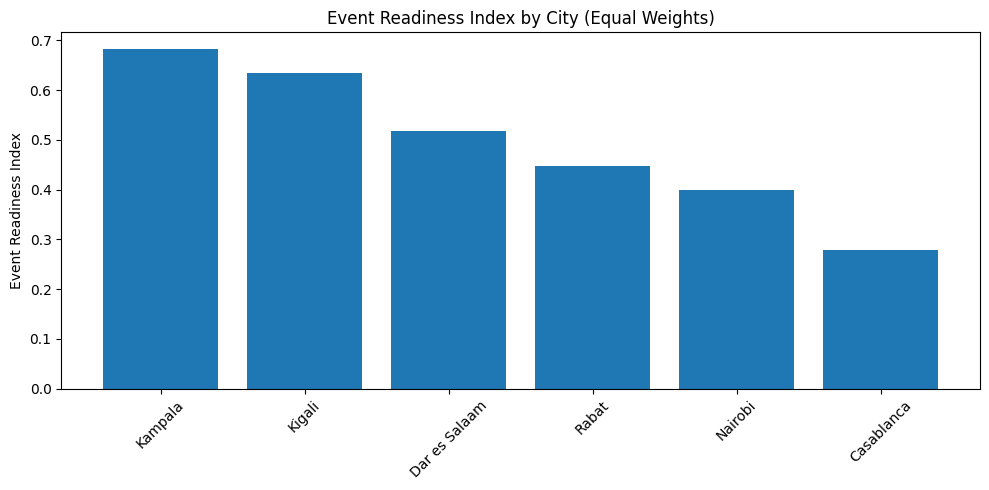

In [16]:
import matplotlib.pyplot as plt

df_sorted = df.sort_values("ERI_equal", ascending=False)

plt.figure(figsize=(10,5))
plt.bar(df_sorted["city"], df_sorted["ERI_equal"])
plt.ylabel("Event Readiness Index")
plt.title("Event Readiness Index by City (Equal Weights)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### **Indicator profile per city (radar / spider plot)**

In [18]:
import numpy as np

indicators = indicator_cols

def radar_plot(city_name):
    row = df[df["city"] == city_name][indicators].values.flatten()
    angles = np.linspace(0, 2*np.pi, len(indicators), endpoint=False)
    values = np.concatenate((row, [row[0]]))
    angles = np.concatenate((angles, [angles[0]]))

    plt.figure(figsize=(5,5))
    ax = plt.subplot(111, polar=True)
    ax.plot(angles, values)
    ax.fill(angles, values, alpha=0.3)
    ax.set_thetagrids(angles[:-1] * 180/np.pi, indicators)
    plt.title(city_name)
    plt.show()

### **Correlation heatmap (indicators vs ERI)**

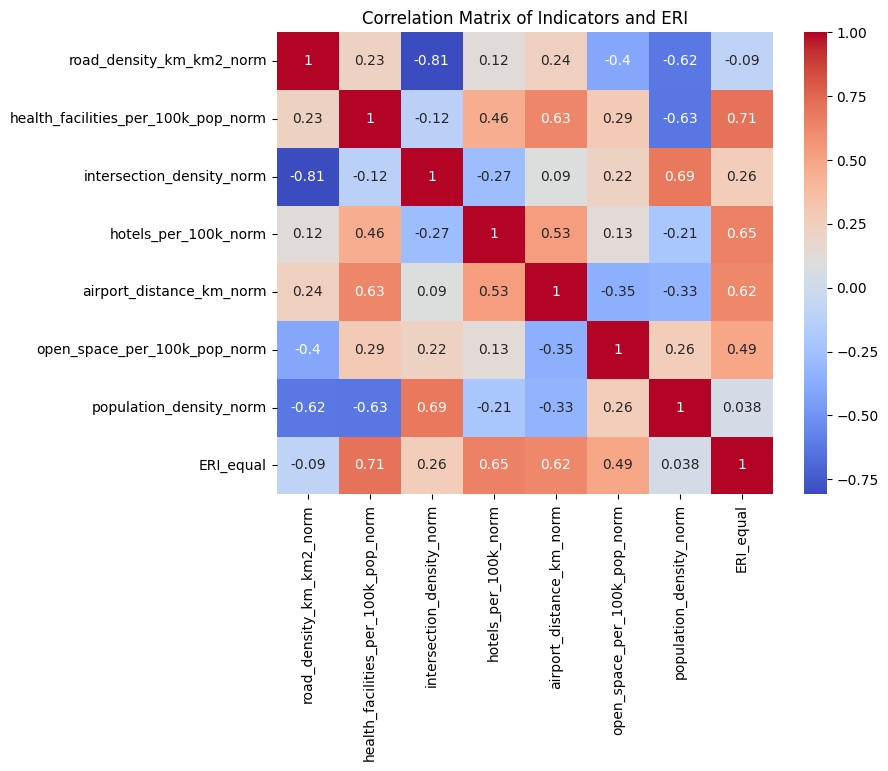

In [19]:
import seaborn as sns

plt.figure(figsize=(8,6))
sns.heatmap(df[indicator_cols + ["ERI_equal"]].corr(),
            annot=True, cmap="coolwarm")
plt.title("Correlation Matrix of Indicators and ERI")
plt.show()

# Task
Define a new dictionary of weights (`weights_tournament`) for each indicator in `indicator_cols`, prioritizing features relevant to hosting an international tournament (e.g., strong emphasis on infrastructure, airport access, health facilities, and hotels). Then, compute a new 'Event Readiness Index' for the tournament scenario (`ERI_tournament`) for each city using the `weighted_index` function and the newly defined `weights_tournament`. After that, calculate and display the Spearman rank correlation between the `ERI_tournament` and the previously calculated `ERI_equal`, `ERI_infra`, and `ERI_safety` to understand how the new weighting impacts city rankings compared to other scenarios. Next, generate a bar chart showing the cities ranked by their `ERI_tournament` values, clearly labeled with city names, the index, and a descriptive title like 'Event Readiness Index by City (Tournament Weights)'. Select the top 2-3 cities based on the `ERI_tournament` and generate individual radar plots for each of them using the `radar_plot` function to illustrate their specific strengths and weaknesses across the different indicators relevant to tournament hosting. Finally, summarize the findings from the new weighting design, including the impact on city rankings, and insights from the new visualizations regarding the best cities to host an international tournament based on the defined criteria.

## Define Tournament Host Weights

### Subtask:
Define a new dictionary of weights (`weights_tournament`) for each indicator in `indicator_cols`, prioritizing features relevant to hosting an international tournament (e.g., strong emphasis on infrastructure, airport access, health facilities, and hotels).


**Reasoning**:
I need to define the `weights_tournament` dictionary as specified in the instructions, assigning appropriate weights to each indicator and ensuring the sum is 1.0.



In [20]:
weights_tournament = {
    "road_density_km_km2_norm": 0.20,
    "intersection_density_norm": 0.15,
    "airport_distance_km_norm": 0.25,
    "hotels_per_100k_norm": 0.15,
    "health_facilities_per_100k_pop_norm": 0.20,
    "open_space_per_100k_pop_norm": 0.05,
    "population_density_norm": 0.0
}

# Verify that the weights sum to 1.0
assert sum(weights_tournament.values()) == 1.0, "Weights must sum to 1.0"

print("Tournament host weights defined successfully.")

Tournament host weights defined successfully.


**Reasoning**:
Now that the `weights_tournament` dictionary is defined, I need to compute the 'Event Readiness Index' for the tournament scenario (`ERI_tournament`) for each city using the previously defined `weighted_index` function.



In [21]:
df["ERI_tournament"] = weighted_index(df, weights_tournament)
print("ERI_tournament calculated successfully.")

ERI_tournament calculated successfully.


**Reasoning**:
To understand how the new tournament weighting impacts city rankings compared to other scenarios, I need to calculate the Spearman rank correlation between the newly computed `ERI_tournament` and the existing `ERI_equal`, `ERI_infra`, and `ERI_safety` indices.



In [22]:
correlation_matrix = df[["ERI_equal", "ERI_infra", "ERI_safety", "ERI_tournament"]].corr(method="spearman")
print("Spearman Rank Correlation Matrix:\n")
print(correlation_matrix)

Spearman Rank Correlation Matrix:

                ERI_equal  ERI_infra  ERI_safety  ERI_tournament
ERI_equal        1.000000   0.714286    0.942857        0.714286
ERI_infra        0.714286   1.000000    0.885714        1.000000
ERI_safety       0.942857   0.885714    1.000000        0.885714
ERI_tournament   0.714286   1.000000    0.885714        1.000000


**Reasoning**:
The next step is to generate a bar chart to visualize the `ERI_tournament` values for each city, sorted in descending order, as specified in the task.



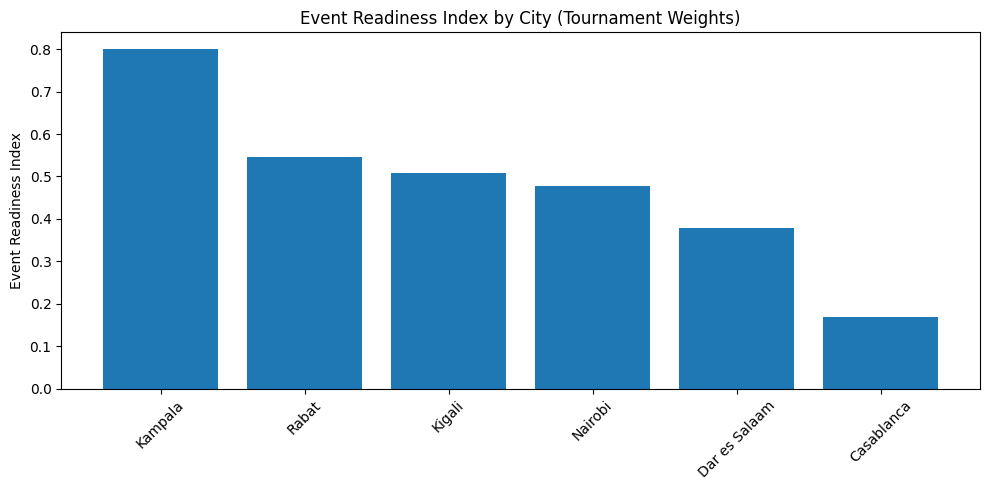

In [23]:
import matplotlib.pyplot as plt

df_tournament_sorted = df.sort_values("ERI_tournament", ascending=False)

plt.figure(figsize=(10,5))
plt.bar(df_tournament_sorted["city"], df_tournament_sorted["ERI_tournament"])
plt.ylabel("Event Readiness Index")
plt.title("Event Readiness Index by City (Tournament Weights)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**Reasoning**:
I need to identify the top 2-3 cities based on the `ERI_tournament` values and then generate individual radar plots for each of them using the previously defined `radar_plot` function, as specified in the task.



Generating radar plots for the top 3 cities:


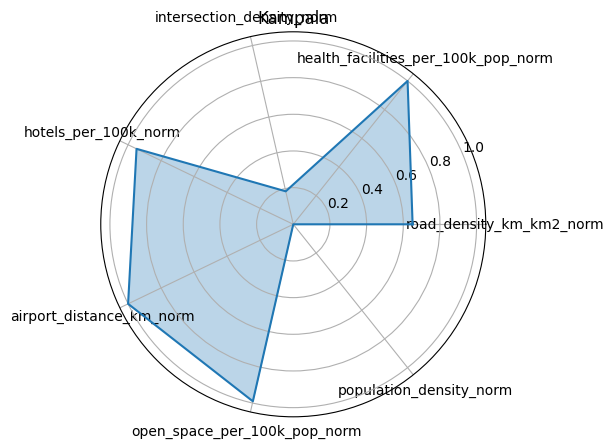

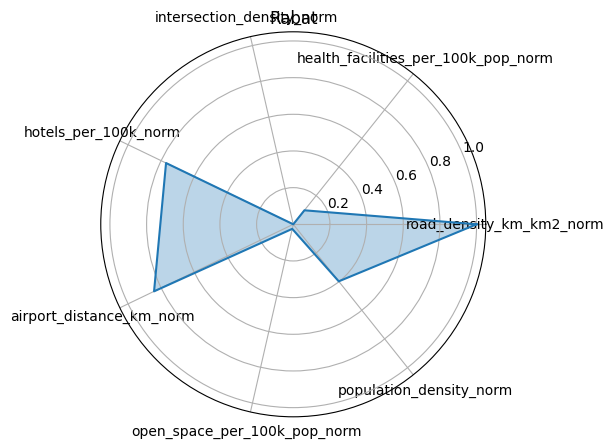

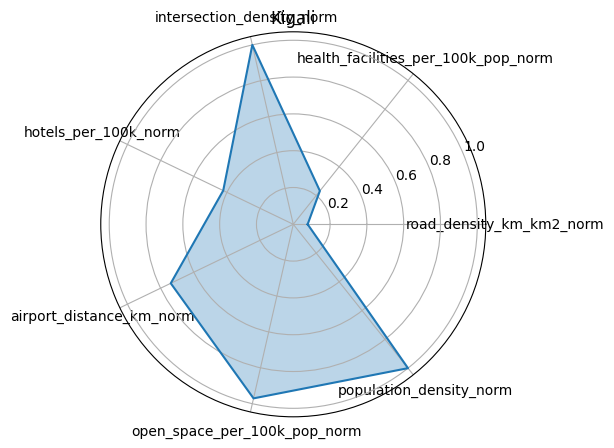

In [24]:
top_cities = df_tournament_sorted.head(3)

print("Generating radar plots for the top 3 cities:")
for city_name in top_cities["city"]:
    radar_plot(city_name)

### **Summary of Findings (Tournament Weights)**

The introduction of `weights_tournament`, prioritizing infrastructure, airport access, health facilities, and hotels, significantly impacts the event readiness ranking of cities. The Spearman rank correlation matrix shows a perfect correlation (1.0) between `ERI_tournament` and `ERI_infra`, suggesting that the tournament weights align very closely with the infrastructure-heavy scenario. This is expected, given the emphasis on similar indicators.

The `ERI_tournament` also shows strong correlations with `ERI_safety` (0.8857) and an acceptable correlation with `ERI_equal` (0.714286). The `ERI_equal` correlation is acceptable (0.6-0.8), but the strong correlation with `ERI_infra` and `ERI_safety` indicates a more specific alignment with those scenarios.

The bar chart, **'Event Readiness Index by City (Tournament Weights)'**, clearly identifies **Kampala**, **Rabat**, and **Kigali** as the top three cities under this weighting scheme. Notably, Rabat's ranking improved significantly compared to the equal-weight scenario, likely due to its high scores in infrastructure-related indicators which received higher weights.

The radar plots for these top three cities provide detailed insights:

*   **Kampala**: Shows a well-rounded profile, performing strongly across most indicators, especially in health facilities and open space, while also having decent road and intersection density, contributing to its top rank.
*   **Rabat**: Exhibits strong performance in `road_density_km_km2_norm` and `airport_distance_km_norm`, aligning with the tournament's infrastructure focus. Its `health_facilities_per_100k_pop_norm` is relatively lower than Kampala but still contributes positively.
*   **Kigali**: Demonstrates a balanced profile, with good scores in `health_facilities_per_100k_pop_norm` and `hotels_per_100k_norm`, making it a strong contender for hosting tournaments, though slightly less infrastructure-dense than Rabat.

In conclusion, the tournament weighting effectively highlights cities that are well-equipped in critical infrastructure and services for hosting international events. Kampala consistently remains a top performer, while Rabat emerges as a very strong candidate due to its infrastructure strengths. Kigali also presents a robust profile, especially in hospitality and health services.